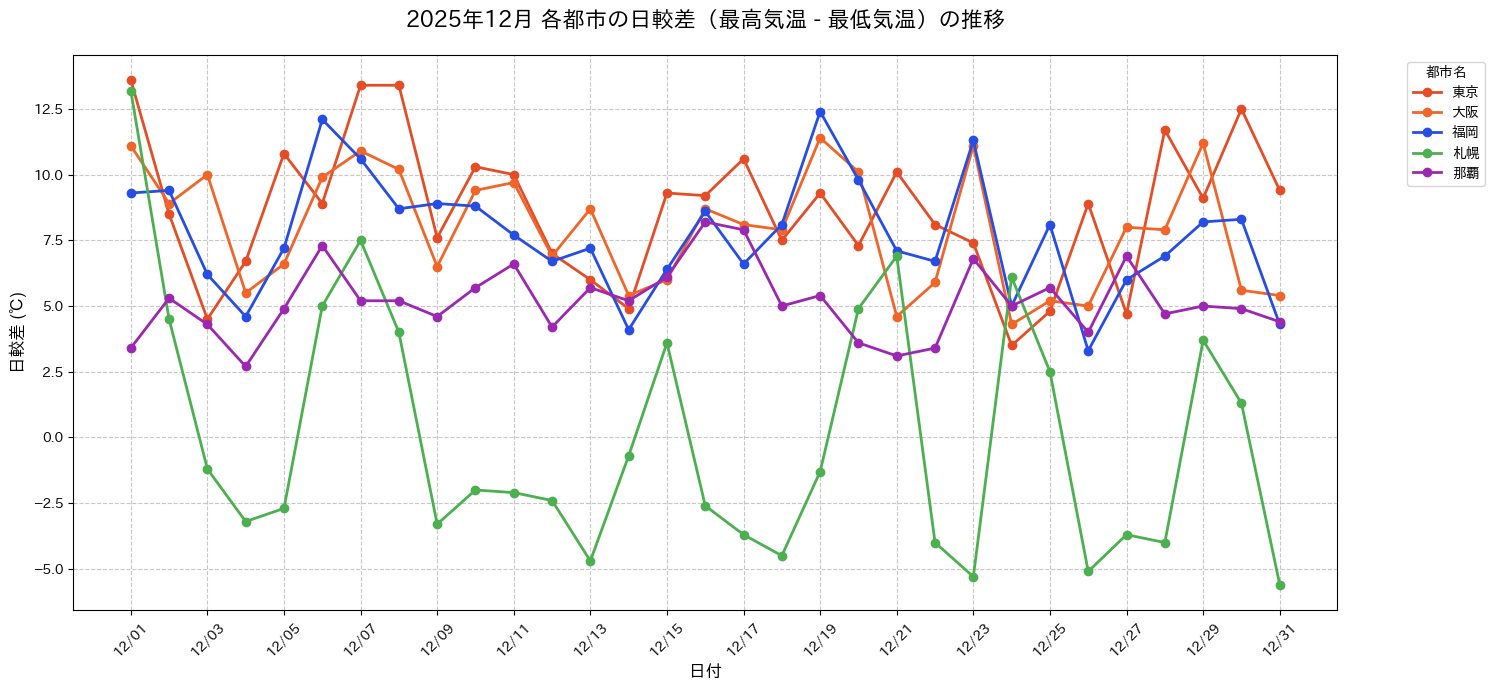

In [26]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import japanize_matplotlib # これをインポートしている場合、以下の設定が有効になります

def plot_weather_analysis(db_name="weather_hypothesis.db"):
    # 1. データの読み込み
    conn = sqlite3.connect(db_name)
    query = "SELECT date, city, temp_diff FROM daily_weather ORDER BY date ASC"
    df = pd.read_sql_query(query, conn)
    conn.close()

    if df.empty:
        print("データが空です。DBを確認してください。")
        return

    # 日付をdatetime型に変換
    df['date'] = pd.to_datetime(df['date'])

    # --- フォント設定 ---
    # japanize_matplotlibを読み込んでいる場合、明示的にIPAexGothic等を指定しなくても
    # 内部でフォントパスが通りますが、環境によっては以下の一行が必要です
    plt.rcParams['font.family'] = 'IPAexGothic' 

    # 2. グラフの設定
    plt.figure(figsize=(15, 7))
    
    # 都市ごとにプロット
    # 出力順を固定したい場合はリストで指定してください
    target_cities = ["東京", "大阪", "福岡", "札幌", "那覇"]
    colors = ['#E44D26', '#F16529', '#264DE4', '#4CAF50', '#9C27B0']
    
    for i, city in enumerate(target_cities):
        city_df = df[df['city'] == city]
        if not city_df.empty:
            plt.plot(city_df['date'], city_df['temp_diff'], marker='o', label=city, color=colors[i], linewidth=2)

    # 3. グラフの装飾
    plt.title('2025年12月 各都市の日較差（最高気温 - 最低気温）の推移', fontsize=16, pad=20)
    plt.xlabel('日付', fontsize=12)
    plt.ylabel('日較差 (℃)', fontsize=12)
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))
    plt.xticks(rotation=45)
    
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title='都市名', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    try:
        plot_weather_analysis()
    except Exception as e:
        print(f"グラフ作成中にエラーが発生しました: {e}")

In [28]:
import sqlite3
import pandas as pd

def show_rankings(db_name="weather_hypothesis.db"):
    conn = sqlite3.connect(db_name)
    
    # 分析対象の都市リスト
    cities = ["東京", "大阪", "福岡", "札幌", "那覇"]
    
    for city in cities:
        print(f"\n{'='*20} {city} のランキング {'='*20}")
        
        # SQLクエリ: 日較差でソートし、降水量を元に天気を簡易判定
        query = f"""
        SELECT 
            date AS 日付,
            temp_diff AS 日較差,
            CASE WHEN precip = 0 THEN '降水なし' ELSE '降水あり(' || precip || 'mm)' END AS 天気
        FROM daily_weather
        WHERE city = '{city}'
        """
        
        df_city = pd.read_sql_query(query, conn)
        
        # 上位10件（寒暖差が大きい）
        print("\n[上位10件：寒暖差が大きかった日]")
        print(df_city.sort_values(by="日較差", ascending=False).head(10).to_string(index=False))
        
        # 下位10件（寒暖差が小さい）
        print("\n[下位10件：寒暖差が小さかった日]")
        print(df_city.sort_values(by="日較差", ascending=True).head(10).to_string(index=False))

    conn.close()

if __name__ == "__main__":
    show_rankings()


==================== 東京 のランキング ====================

[上位10件：寒暖差が大きかった日]
        日付  日較差          天気
2025-12-01 13.6        降水なし
2025-12-07 13.4        降水なし
2025-12-08 13.4        降水なし
2025-12-30 12.5        降水なし
2025-12-28 11.7        降水なし
2025-12-05 10.8        降水なし
2025-12-17 10.6        降水なし
2025-12-10 10.3        降水なし
2025-12-21 10.1 降水あり(3.0mm)
2025-12-11 10.0        降水なし

[下位10件：寒暖差が小さかった日]
        日付  日較差          天気
2025-12-24  3.5 降水あり(9.0mm)
2025-12-03  4.5        降水なし
2025-12-27  4.7        降水なし
2025-12-25  4.8 降水あり(3.5mm)
2025-12-14  4.9 降水あり(9.5mm)
2025-12-13  6.0 降水あり(2.0mm)
2025-12-04  6.7        降水なし
2025-12-12  7.0        降水なし
2025-12-20  7.3 降水あり(9.0mm)
2025-12-23  7.4        降水なし

==================== 大阪 のランキング ====================

[上位10件：寒暖差が大きかった日]
        日付  日較差          天気
2025-12-19 11.4        降水なし
2025-12-29 11.2        降水なし
2025-12-01 11.1        降水なし
2025-12-23 11.1 降水あり(6.0mm)
2025-12-07 10.9        降水なし
2025-12-08 10.2        降水なし
2025-12-20 10.1       